In [17]:
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
from scipy import linalg as LA
import pandas as pd
import time, os
import matplotlib.pyplot as plt

from pyinstrument import Profiler
import Ipynb_importer

from infoband.band_info import InfoCorrBand
from wlpy.covariance import Covariance
from utils.adpt_correlation_threshold import AdptCorrThreshold
from wlpy.gist import heatmap

import warnings
warnings.filterwarnings("ignore")

from my_api import *

# other estimator

In [2]:
N_T_range = [100, 300, 500]
rho_range = [0.8, 0.95]

In [6]:
# df = pd.DataFrame(columns = ['Id', 'Sample', 'Soft Threshold', 'Hard Threshold', 'Linear Shrink', 'Nonlinear Shrink'])

In [7]:
df = pd.DataFrame(columns = ['N', 'T', 'rho', 'ord', 'type', 'Sample', 'Soft Threshold', 'Hard Threshold', 'Linear Shrink', 'Nonlinear Shrink'])

In [8]:
for N in N_T_range:
    for T in N_T_range:
        for rho in rho_range:
            for ord in ['fro', 2]:
                # data and true matrix
                S = gen_S_AR1(rho, N)
                R = cov2cor(S)
                seed = 1
                rng = np.random.RandomState(seed) if 1 else np.random
                X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
                
                # esti object
                G_zero = np.ones((N, N)) - np.eye(N)
                m = AdptCorrThreshold(pd.DataFrame(X), G_zero)
                
                # other estimator
                R_ths, S_ths, _ = m.auto_fit(threshold_method = 'soft threshold')
                R_thh, S_thh, _ = m.auto_fit(threshold_method = 'hard threshold')
                S_lin, S_sample = m.lw_lin_shrink(), m.sample_cov()
                R_lin, R_sample = cov2cor(S_lin), cov2cor(S_sample)
                if T > N:
                    S_nlin = m.nonlin_shrink()
                    R_nlin = cov2cor(S_nlin)
                
                # correlation
                # row = {}
                # row['Id'] = (N, T, rho, ord, 'R')
                row = {'N': N, 'T': T, 'rho': rho, 'ord': ord, 'type': 'R'}
                deno = LA.norm(R, ord)
                row['Sample'] = LA.norm(R_sample - R, ord) / deno
                row['Soft Threshold'] = LA.norm(R_ths - R, ord) / deno
                row['Hard Threshold'] = LA.norm(R_thh - R, ord) / deno
                row['Linear Shrink'] = LA.norm(R_lin - R, ord) / deno
                if T > N:
                    row['Nonlinear Shrink'] = LA.norm(R_nlin - R, ord) / deno
                # df.loc[Id, 'Sample'] = LA.norm(R_sample - R, ord) / deno
                # df.loc[Id, 'Soft Threshold'] = LA.norm(R_ths - R, ord) / deno
                # df.loc[Id, 'Hard Threshold'] = LA.norm(R_thh - R, ord) / deno
                # df.loc[Id, 'Linear Shrink'] = LA.norm(R_lin - R, ord) / deno
                # df.loc[Id, 'Nonlinear Shrink'] = LA.norm(R_nlin - R, ord) / deno
                df = df.append(row, ignore_index = True)
                # covariance
                # row['Id'] = (N, T, rho, ord, 'S')
                row = {'N': N, 'T': T, 'rho': rho, 'ord': ord, 'type': 'S'}
                deno = LA.norm(S, ord)
                row['Sample'] = LA.norm(S_sample - S, ord) / deno
                row['Soft Threshold'] = LA.norm(S_ths - S, ord) / deno
                row['Hard Threshold'] = LA.norm(S_thh - S, ord) / deno
                row['Linear Shrink'] = LA.norm(S_lin - S, ord) / deno
                if T > N:
                    row['Nonlinear Shrink'] = LA.norm(S_nlin - S, ord) / deno
                df = df.append(row, ignore_index = True)
                # df.loc[Id, 'Sample'] = LA.norm(S_sample - S, ord) / deno
                # df.loc[Id, 'Soft Threshold'] = LA.norm(S_ths - S, ord) / deno
                # df.loc[Id, 'Hard Threshold'] = LA.norm(S_thh - S, ord) / deno
                # df.loc[Id, 'Linear Shrink'] = LA.norm(S_lin - S, ord) / deno
                # df.loc[Id, 'Nonlinear Shrink'] = LA.norm(S_nlin - S, ord) / deno
                print(df.iloc[-1], df.iloc[-2], sep = '\n')

N                        100
T                        100
rho                      0.8
ord                      fro
type                       S
Sample              0.468781
Soft Threshold      0.423442
Hard Threshold      0.468781
Linear Shrink       0.419056
Nonlinear Shrink         NaN
Name: 1, dtype: object
N                        100
T                        100
rho                      0.8
ord                      fro
type                       R
Sample              0.437159
Soft Threshold      0.412584
Hard Threshold      0.437159
Linear Shrink       0.405599
Nonlinear Shrink         NaN
Name: 0, dtype: object
N                        100
T                        100
rho                      0.8
ord                        2
type                       S
Sample              0.487316
Soft Threshold      0.438334
Hard Threshold      0.431773
Linear Shrink       0.471418
Nonlinear Shrink         NaN
Name: 3, dtype: object
N                        100
T                        100
rho

In [25]:
# df[(df['Nonlinear Shrink'].isnull() == False) & (df['Nonlinear Shrink'] > df['Linear Shrink'])]

,Id,Sample,Soft Threshold,Hard Threshold,Linear Shrink,Nonlinear Shrink
13,"(100, 300, 0.95, fro, S)",0.131696,0.131447,0.142116,0.119872,0.125182
14,"(100, 300, 0.95, 2, R)",0.061406,0.049749,0.062852,0.049436,0.050888
15,"(100, 300, 0.95, 2, S)",0.121790,0.105651,0.112374,0.099106,0.108539
20,"(100, 500, 0.95, fro, R)",0.066085,0.064171,0.066085,0.064795,0.065223
21,"(100, 500, 0.95, fro, S)",0.099378,0.090916,0.099378,0.092430,0.095949
22,"(100, 500, 0.95, 2, R)",0.049238,0.056742,0.049433,0.042280,0.044874
23,"(100, 500, 0.95, 2, S)",0.092289,0.067021,0.092275,0.079431,0.084915
45,"(300, 500, 0.95, fro, S)",0.180067,0.180067,0.178428,0.168953,0.169377
47,"(300, 500, 0.95, 2, S)",0.189935,0.140667,0.143486,0.158380,0.159373


In [18]:
df.to_csv('other_methods.csv')

# data processing

In [37]:
df = pd.read_csv('other_methods.csv')
df.drop(columns = df.columns[0], inplace = True)
df.head(3)

,N,T,rho,ord,type,Sample,Soft Threshold,Hard Threshold,Linear Shrink,Nonlinear Shrink
0,100,100,0.8,fro,R,0.437159,0.412584,0.437159,0.405599,NaN
1,100,100,0.8,fro,S,0.468781,0.423442,0.468781,0.419056,NaN
2,100,100,0.8,2,R,0.419901,0.411377,0.348096,0.455421,NaN


In [38]:
data_path = 'data_2023-01-14/'

def compute_error(row, eta):
    N, T, rho, ord, type = row['N'], row['T'], row['rho'], row['ord'], row['type']
    if type == 'R':
        cov_cor = 'cor'
    else:
        cov_cor = 'cov'
    file_name = get_title_1(ord = ord, cov_cor = cov_cor, eta = eta, N = N, T = T, rho = rho, draw_type = 'random')
    file_path = data_path + file_name + '.txt'
    try:
        data = np.loadtxt(file_path)
        return data.mean()
    except FileNotFoundError as e:
        return None

In [39]:
eta_range = [0.5, 0.8, 0.95, 1]

In [40]:
for eta in eta_range:
    df['Info Band eta={}'.format(eta)] = df.apply(func = compute_error, axis = 1, args = (eta, ))

In [41]:
df[df['Info Band eta=0.5'].isnull() == False].head()

,N,T,rho,ord,type,Sample,Soft Threshold,Hard Threshold,Linear Shrink,Nonlinear Shrink,Info Band eta=0.5,Info Band eta=0.8,Info Band eta=0.95,Info Band eta=1
24,300,100,0.80,fro,R,0.788400,0.341773,0.880962,0.575247,NaN,0.391015,0.299953,0.220001,0.220003
25,300,100,0.80,fro,S,0.839914,0.359178,0.884476,0.581832,NaN,0.433204,0.357403,0.295806,0.295807
26,300,100,0.80,2,R,0.978462,0.398644,0.887738,0.635389,NaN,0.289494,0.196713,0.198978,NaN
27,300,100,0.80,2,S,1.118217,0.444021,0.887002,0.631918,NaN,0.324393,0.278380,0.333266,NaN
28,300,100,0.95,fro,R,0.345589,0.288438,0.973157,0.310277,NaN,0.447366,0.321296,0.231754,0.204468


### query

In [44]:
tmp = df[(df['ord'] == 'fro') & (df['type'] == 'S') & (df['N'] > df['T'])]
tmp.shape

(6, 14)

In [45]:
tmp

,N,T,rho,ord,type,Sample,Soft Threshold,Hard Threshold,Linear Shrink,Nonlinear Shrink,Info Band eta=0.5,Info Band eta=0.8,Info Band eta=0.95,Info Band eta=1
25,300,100,0.80,fro,S,0.839914,0.359178,0.884476,0.581832,NaN,0.433204,0.357403,0.295806,0.295807
29,300,100,0.95,fro,S,0.439947,0.285761,0.974010,0.349928,NaN,0.497606,0.394539,0.327522,0.309901
49,500,100,0.80,fro,S,1.047401,0.419410,0.880104,0.679519,NaN,0.396283,0.319619,0.262429,0.267048
53,500,100,0.95,fro,S,0.518841,0.392081,0.973919,0.450736,NaN,0.475640,0.356634,0.274209,0.251642
57,500,300,0.80,fro,S,0.609856,0.273069,0.883377,0.508406,NaN,0.335240,0.244207,0.171480,0.164404
61,500,300,0.95,fro,S,0.314768,0.235500,0.973713,0.297102,NaN,0.408357,0.295583,0.202708,0.169351


In [47]:
tmp = df[(df['N'] == 500)]
tmp


,N,T,rho,ord,type,Sample,Soft Threshold,Hard Threshold,Linear Shrink,Nonlinear Shrink,Info Band eta=0.5,Info Band eta=0.8,Info Band eta=0.95,Info Band eta=1
48,500,100,0.80,fro,R,1.046652,0.403661,0.877496,0.677967,NaN,0.371348,0.285833,0.218473,0.224191
49,500,100,0.80,fro,S,1.047401,0.419410,0.880104,0.679519,NaN,0.396283,0.319619,0.262429,0.267048
50,500,100,0.80,2,R,1.476639,0.496660,0.883962,0.763013,NaN,0.338383,0.250428,0.217734,0.224883
51,500,100,0.80,2,S,1.469895,0.530165,0.888774,0.766108,NaN,0.396817,0.322420,0.296515,0.299564
52,500,100,0.95,fro,R,0.499266,0.379502,0.973517,0.438361,NaN,0.459265,0.331139,0.237467,0.210420
53,500,100,0.95,fro,S,0.518841,0.392081,0.973919,0.450736,NaN,0.475640,0.356634,0.274209,0.251642
54,500,100,0.95,2,R,0.638519,0.726931,0.974028,0.447506,NaN,0.320237,0.225475,0.179517,0.171598
55,500,100,0.95,2,S,0.691658,0.737535,0.974306,0.466810,NaN,0.367239,0.282871,0.248989,0.260641
56,500,300,0.80,fro,R,0.611694,0.258052,0.882593,0.505437,NaN,0.324812,0.228630,0.147491,0.139134
57,500,300,0.80,fro,S,0.609856,0.273069,0.883377,0.508406,NaN,0.335240,0.244207,0.171480,0.164404


# -----------------------------------------------------

In [2]:
# profiler = Profiler()
# profiler.start()

N = 100
T = 300
rho = 0.95
S = gen_S_AR1(N = N, rho = rho)
R = cov2cor(S)

seed = 1
rng = np.random.RandomState(seed) if 1 else np.random
X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)

# profiler.stop()
# profiler.print()

In [31]:
# G_zero = np.zeros((N, N))
G_zero = np.ones((N, N)) - np.eye(N)
m = AdptCorrThreshold(pd.DataFrame(X), G_zero)

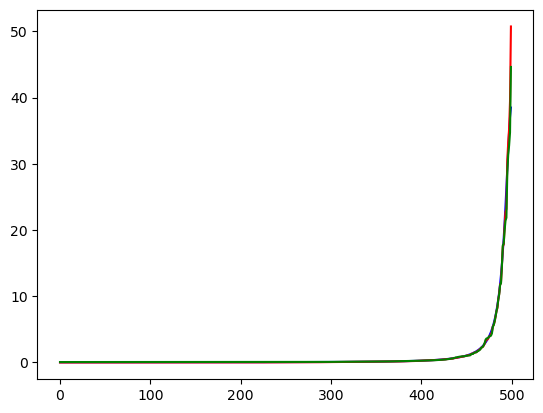

In [40]:
plt.plot(np.linalg.eigvals(S)[::-1], color = 'blue');
plt.plot(np.sort(np.linalg.eigvals(m.sample_cov())), color = 'red');
plt.plot(np.sort(np.linalg.eigvals(m.nonlin_shrink())), color = 'green');
# plt.plot(np.sort(np.linalg.eigvals(m.lw_lin_shrink())), color = 'purple');

In [1]:
# help('numpy.linalg.eigvals')

In [34]:
# np.linalg.eigvals(S)[::-1]
# np.linalg.eigvals(m.sample_cov())[::-1]

In [36]:
def show_rs(S: np.ndarray, 
            m: AdptCorrThreshold, 
            ord = 'fro'):
    # ord: norm type
    R_ths, S_ths, params = m.auto_fit(threshold_method = 'soft threshold')
    print(params)
    R_thh, S_thh, params = m.auto_fit(threshold_method = 'hard threshold')
    print(params)
    R = cov2cor(S)
    
    print(ord)
    print('----------'*2)
    
    x = LA.norm(R, ord)
    print('Correlation itself', x)
    print('Error:')
    print('Sample', LA.norm(cov2cor(m.sample_cov()) - R, ord) / x)
    print('Linear Shrinkage', LA.norm(cov2cor(m.lw_lin_shrink()) - R, ord) / x)
    print('Nonlinear Shrinkage', LA.norm(cov2cor(m.nonlin_shrink()) - R, ord) / x)
    print('Soft Threshold', LA.norm(R_ths - R, ord) / x)
    print('Hard Threshold', LA.norm(R_thh - R, ord) / x)
    for eta in [0.5, 0.8, 0.95, 1]:
        try:
            mean_err = np.loadtxt('data_done/' + get_title_1(ord, 'cor', 'random', eta, N, T, rho) + '.txt').mean()
            print('Info Band, eta={}'.format(eta), mean_err)
        except Exception:
            pass
        
    print()
    
    x = LA.norm(S, ord)
    print('Covariance itself', x)
    print('Error:')
    print('Sample', LA.norm(m.sample_cov() - S, ord) / x)
    print('Linear Shrinkage', LA.norm(m.lw_lin_shrink() - S, ord) / x)
    print('Nonlinear Shrinkage', LA.norm(m.nonlin_shrink() - S, ord) / x)
    print('Soft Threshold', LA.norm(S_ths - S, ord) / x)
    print('Hard Threshold', LA.norm(S_thh - S, ord) / x)
    for eta in [0.5, 0.8, 0.95, 1]:
        try:
            mean_err = np.loadtxt('data_done/' + get_title_1(ord, 'cov', 'random', eta, N, T, rho) + '.txt').mean()
            print('Info Band, eta={}'.format(eta), mean_err)
        except Exception:
            pass
    
    print('----------'*2)
    return

In [39]:
print(N, T, rho)
show_rs(S, m, 'fro')
show_rs(S, m, 2)
# show_rs(S, m, 1)

[ 6.43220455e-01 -6.03734560e-04]
[ 6.71717172e+00 -1.55865402e-12]
fro
--------------------
Correlation itself 97.80866615094732
Error:
Sample 0.30145095089923946
Linear Shrinkage 0.2839944980445308
Nonlinear Shrinkage 0.2732307754636863
Soft Threshold 0.21751200955816563
Hard Threshold 0.9735165500676309

Covariance itself 97.80866615094732
Error:
Sample 0.3147680811469419
Linear Shrinkage 0.2971016162330117
Nonlinear Shrinkage 0.28522658188781924
Soft Threshold 0.2366022311315699
Hard Threshold 0.9737125716827223
--------------------
[ 2.41818635e-08 -1.97730196e-12]
[ 0.25467745 -0.2535231 ]
2
--------------------
Correlation itself 38.50264813100928
Error:
Sample 0.4033757099900365
Linear Shrinkage 0.3067950387124192
Nonlinear Shrinkage 0.26779469092129193
Soft Threshold 0.9740277604647505
Hard Threshold 0.9740277604647505

Covariance itself 38.50264813100928
Error:
Sample 0.43164797923813863
Linear Shrinkage 0.3292782219862578
Nonlinear Shrinkage 0.2930379819326254
Soft Threshold

# ----------------------------
plot the distribution of error rates

In [ ]:
# res1 = []
# res2 = []

In [ ]:
for i in range(200):
    L1 = gen_L(S, eta = 0.5, verbose = 0, 
            draw_type = 'near', is_random = 1)
    c1 = InfoCorrBand(X = X, L = L1, num_cv = 20)
    # R_est1, S_est1, k1 = c1.auto_fit()
    res = c1.auto_fit()
    res1.append(res)
    # print(res[2])

20
18
18
6
17
15
19
19
6
10
6
7
7
16
22
24
19
17
4
7
16
20
3
17
21
25
6
7
8
22
5
23
16
21
21
14
4


KeyboardInterrupt: 

# --------------------

In [ ]:
for ord in ['fro', 2, 1]:
    print(ord, 'cor')
    print(LA.norm(R - R_est, ord))
    print(LA.norm(R - R_est1, ord))
    print(LA.norm(R - R_est2, ord))
    print(ord, 'cov')
    print(LA.norm(S - S_est, ord))
    print(LA.norm(S - S_est1, ord))
    print(LA.norm(S - S_est2, ord))

fro cor
5.3547379898153045
6.452088354585957
12.623341873998882
fro cov
8.20827979110684
8.9617152976866
13.40982410842072
2 cor
1.7832402677573187
1.769745999552205
4.998685228078624
2 cov
4.977860270444561
4.96973660159217
5.091390155453619
1 cor
3.9752892005894385
4.283611905894455
6.733673932336882
1 cov
8.690140091661135
8.734167335328328
8.482216067368222


In [ ]:
df = pd.DataFrame({'a':[[2,3],2,3]})
df

,a
0,"[2, 3]"
1,2
2,3


In [ ]:
# heatmap(R)
# heatmap(R_est)
# heatmap(R_est1)
# heatmap(R_est2)
# heatmap(c.sample_corr())

In [ ]:
c.auto_fit()

(array([[1.        , 0.75607612, 0.57857393, ..., 0.        , 0.        ,
         0.        ],
        [0.75607612, 1.        , 0.81429886, ..., 0.        , 0.        ,
         0.        ],
        [0.57857393, 0.81429886, 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.81889317,
         0.66621149],
        [0.        , 0.        , 0.        , ..., 0.81889317, 1.        ,
         0.84207442],
        [0.        , 0.        , 0.        , ..., 0.66621149, 0.84207442,
         1.        ]]),
 array([[1.06586502, 0.75682257, 0.58198612, ..., 0.        , 0.        ,
         0.        ],
        [0.75682257, 0.94005854, 0.76924368, ..., 0.        , 0.        ,
         0.        ],
        [0.58198612, 0.76924368, 0.94930403, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.98563935, 0.82672521,
         0.81246694],
        [0. 

In [ ]:
class time_printer():
    def __init__(self):
        self.t = time.time()
        self.t_next = None
        
    def tick(self):
        self.t_next = time.time()
        print("    Time Interval: {}".format(self.t_next - self.t))
        self.t = self.t_next

In [ ]:
is_random = False
rng = (random if is_random else np.random.RandomState(100)) # 300_300:101. other: 100
N = 400
T = 300
res = []
rho_range = [0.8, 0.9, 0.95, 0.99]
eta_range = [0.5, 0.8, 1]
ord_range = ['fro', 2]
near_factor_range = [0.5, 1, 2]
tp = time_printer()

In [ ]:
print(N, T)
for rho in rho_range:
    print("rho: ", rho)
    
    S = gen_S_AR1(rho = rho, N = N)
    R = cov2cor(S)
    X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
    
    m = Covariance(X)
    S_l = m.lw_lin_shrink()
    R_l = cov2cor(S_l)
    S_nl = m.nonlin_shrink()
    R_nl = cov2cor(S_nl)
    
    tp.tick()
    
    for eta in eta_range:
        for near_factor in near_factor_range:
            print("eta, near_factor: ", eta, near_factor)
            
            L = gen_L(S, eta, 
                draw_type = 'near', 
                is_random = is_random, 
                near_factor = near_factor)   
            
            tp.tick()
                
            c = InfoCorrBand(X, L)
            
            tp.tick()
            
            R_est, S_est = c.auto_fit()[:2]
            
            tp.tick()
            
            for ord in ord_range:   
                print("ord: ", ord)
                
                dct_cov = {'group': 'S', 
                    'norm type': ord, 
                    'rho': rho, 
                    'eta': eta, 
                    'near factor': near_factor, 
                    'S or R': LA.norm(S, ord), 
                    'Sample': LA.norm(c.sample_cov() - S, ord), 
                    'Linear Shrinkage': LA.norm(S_l - S, ord), 
                    'Nonlinear Shrinkage': LA.norm(S_nl - S, ord), 
                    'Info Band': LA.norm(S_est - S, ord)}
                dct_cor = {'group': 'R', 
                    'norm type': ord, 
                    'rho': rho, 
                    'eta': eta, 
                    'near factor': near_factor, 
                    'S or R': LA.norm(R, ord), 
                    'Sample': LA.norm(c.sample_corr() - R, ord), 
                    'Linear Shrinkage': LA.norm(R_l - R, ord), 
                    'Nonlinear Shrinkage': LA.norm(R_nl - R, ord), 
                    'Info Band': LA.norm(R_est - R, ord)}
                res += [dct_cov, dct_cor]
                
                tp.tick()

400 300
rho:  0.8
    Time Interval: 0.9151647090911865
eta, near_factor:  0.5 0.5
    Time Interval: 4.885119199752808
    Time Interval: 0.07583808898925781


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(res)
df

In [ ]:
path = 'resultData/'
file_name = 'result_' + str(N) + '-' + str(T) + '.csv'
df.to_csv(path + file_name)
# df.to_csv(path + file_name, float_format = '%.5f') 

dataframe 追加模式 https://blog.csdn.net/lost0910/article/details/105321888

# test

In [ ]:
N = 400
T = 400
S = gen_S_AR1(rho = 0.9, N = N)
R = cov2cor(S)
X = np.random.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
m = Covariance(X)
S_nl = m.nonlin_shrink()
print(S_nl)
lam, u = np.linalg.eigh(m.sample_cov())
print(lam)